# Run Analysis

This notebook analyze the information generated by the experiment I had for **m4 daily finance dataset**. There are two remarks to the configuration:

- log-return target transformation is applied after DC transformation
- DC transformation was given the opportunity to choose between Akima and linear interpolation.

Other information about the run:

- a total of 20 time series are run
- models involved are EN, MLP, RF, LGBM, ETS, and LSVR
- gap = 0
- horiozn = 1
- retrain window = 10

In [1]:
import os
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from pprint import pprint

plt.rcParams['figure.figsize'] = (20, 8)
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

Load run information

In [2]:
plt.style.use('ggplot')

In [3]:
runs = ['12-07-2022--17-41-28']

run_infos = []

for run in runs:
    with open(f'{run}/run_info.json', 'r') as file:
        run_infos.append(json.load(file))

pprint(run_infos)

[{'Avg. len of series': 1229.45,
  'config input': {'dataset': {'cumulate used': 0,
                               'file name': 'm4_daily_finance.json',
                               'file path': 'datasets/',
                               'file type': 'json',
                               'max length': 1500,
                               'min length': 1000,
                               'use series': 20},
                   'execution config': {'n of workers': 24},
                   'modelling config': {'forecast horizon': 1,
                                        'gap': 0,
                                        'retrain window': 10,
                                        'score measure': 'SMAPE',
                                        'test size': 0.1,
                                        'validation size': 0.1},
                   'models': ['EN', 'MLP', 'LSVR', 'RF', 'LGBM', 'ETS'],
                   'transformation config': {'interp kind': ['linear', 'akima'],
       

Load agents' run information

In [4]:
agent_infos_raw = {}

for i, run in enumerate(run_infos):
    run_id = run['run time'][0]
    models = run['config input']['models']

    for m in models:

        agent_1 = f'{m}_raw'
        agent_2 = f'{m}_tran'

        if i == 0:
            with open(f'{run_id}/{agent_1}.json', 'r') as file:
                agent_infos_raw[agent_1] = json.load(file)
            with open(f'{run_id}/{agent_2}.json', 'r') as file:
                agent_infos_raw[agent_2] = json.load(file)
        else:
            with open(f'{run_id}/{agent_1}.json', 'r') as file:
                agent_infos_raw[agent_1] = {**agent_infos_raw[agent_1], **json.load(file)}
            with open(f'{run_id}/{agent_2}.json', 'r') as file:
                agent_infos_raw[agent_2] = {**agent_infos_raw[agent_2], **json.load(file)}


In [5]:
agent_infos_raw = dict( sorted(agent_infos_raw.items(), key=lambda x: x[0].lower()) )

list(agent_infos_raw.keys())

['EN_raw',
 'EN_tran',
 'ETS_raw',
 'ETS_tran',
 'LGBM_raw',
 'LGBM_tran',
 'LSVR_raw',
 'LSVR_tran',
 'MLP_raw',
 'MLP_tran',
 'RF_raw',
 'RF_tran']

Check if all time series have been played successfully. Exclude those which not all agents have played successfully.

In [6]:
agent_fails = {k: [] for k in agent_infos_raw.keys()}
series_excluded = []

for agent, plays in agent_infos_raw.items():
    for series, info in plays.items():
        if info['message'] != None:
            agent_fails[agent].append(series)
            series_excluded.append(series)

if not series_excluded:
    print('All agents have successfully ran on all series.')
else:
    print(series_excluded)
    print(agent_fails)

All agents have successfully ran on all series.


Get analysis only on the series played by all agents.

In [7]:
played = [set(plays.keys()) for plays in agent_infos_raw.values()]
played_by_all = played[0].intersection(*played[1:])
print('Series played by all agents: ')
print(played_by_all)

Series played by all agents: 
{'2439', '2044', '2315', '2078', '2137', '2080', '2214', '2040', '2081', '2484', '2041', '2425', '2045', '2483', '2310', '2432', '2292', '2370', '2317', '2440'}


In [8]:
dict_filter = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ]) # large, filter keys

agent_infos = {agent: dict_filter(plays, played_by_all) for agent, plays in agent_infos_raw.items()}

## A glance at model prediction

Before digging into the details, take a quick look on how the model is doing on the tests. In this section, I manually took two time series that was played by all agents. One of the time series exhibits an exogeneous shock in the testing set. I took time series number 1 from m4_daily.json

In [9]:
# the time series
with open('m4_daily_finance_2.json', 'r') as file:
    ts = json.load(file)

print(ts.keys())

use = '2440'

dict_keys(['2040', '2440'])


In [10]:
# filter out the test set

test_size = run_infos[0]['config input']['modelling config']['test size']
test_set_count = int(len(ts[use]) * test_size)

test_set = ts[use][-(test_set_count):]

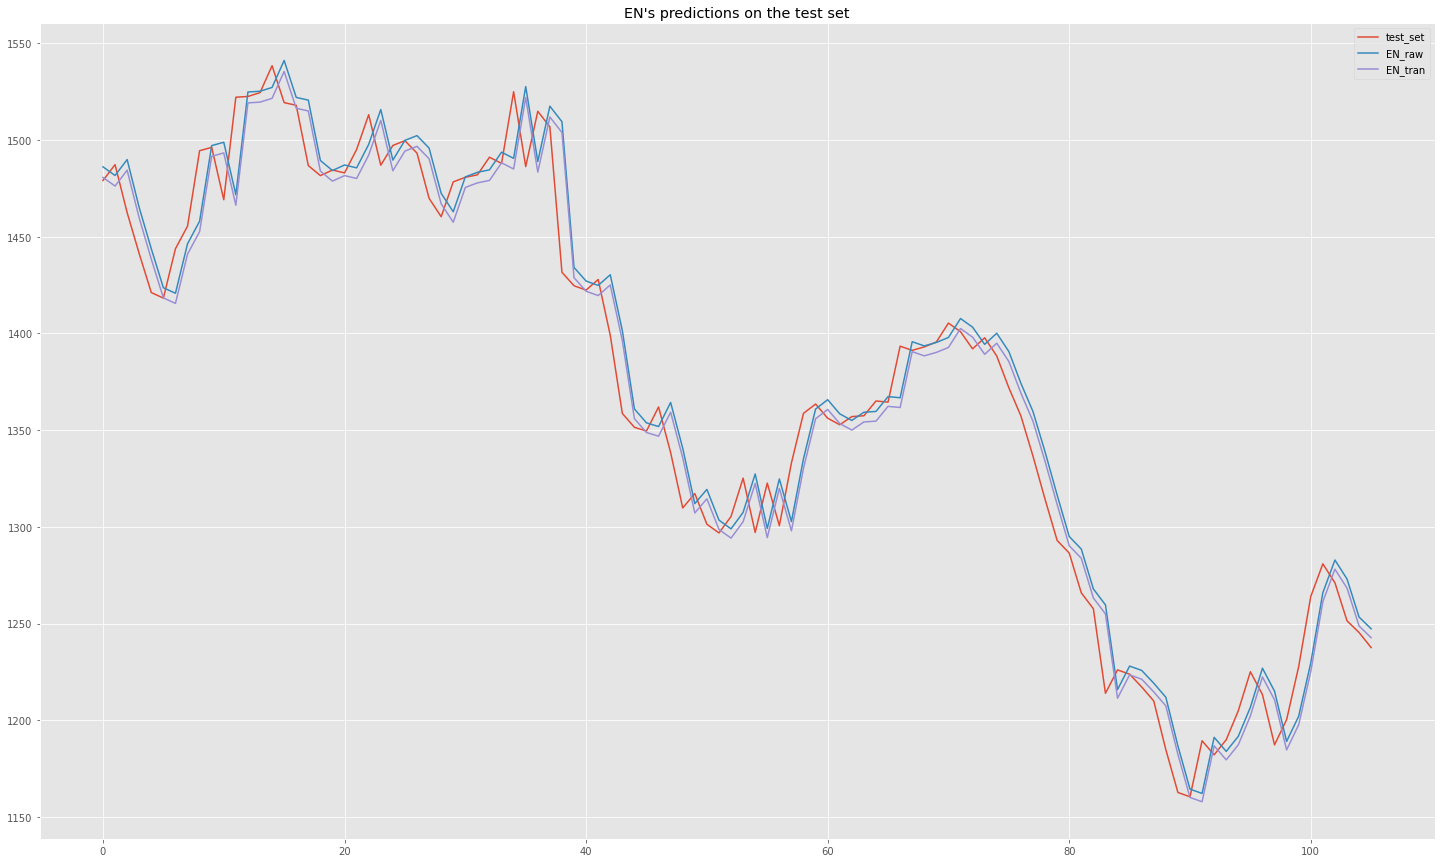

In [11]:
model = 'EN'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

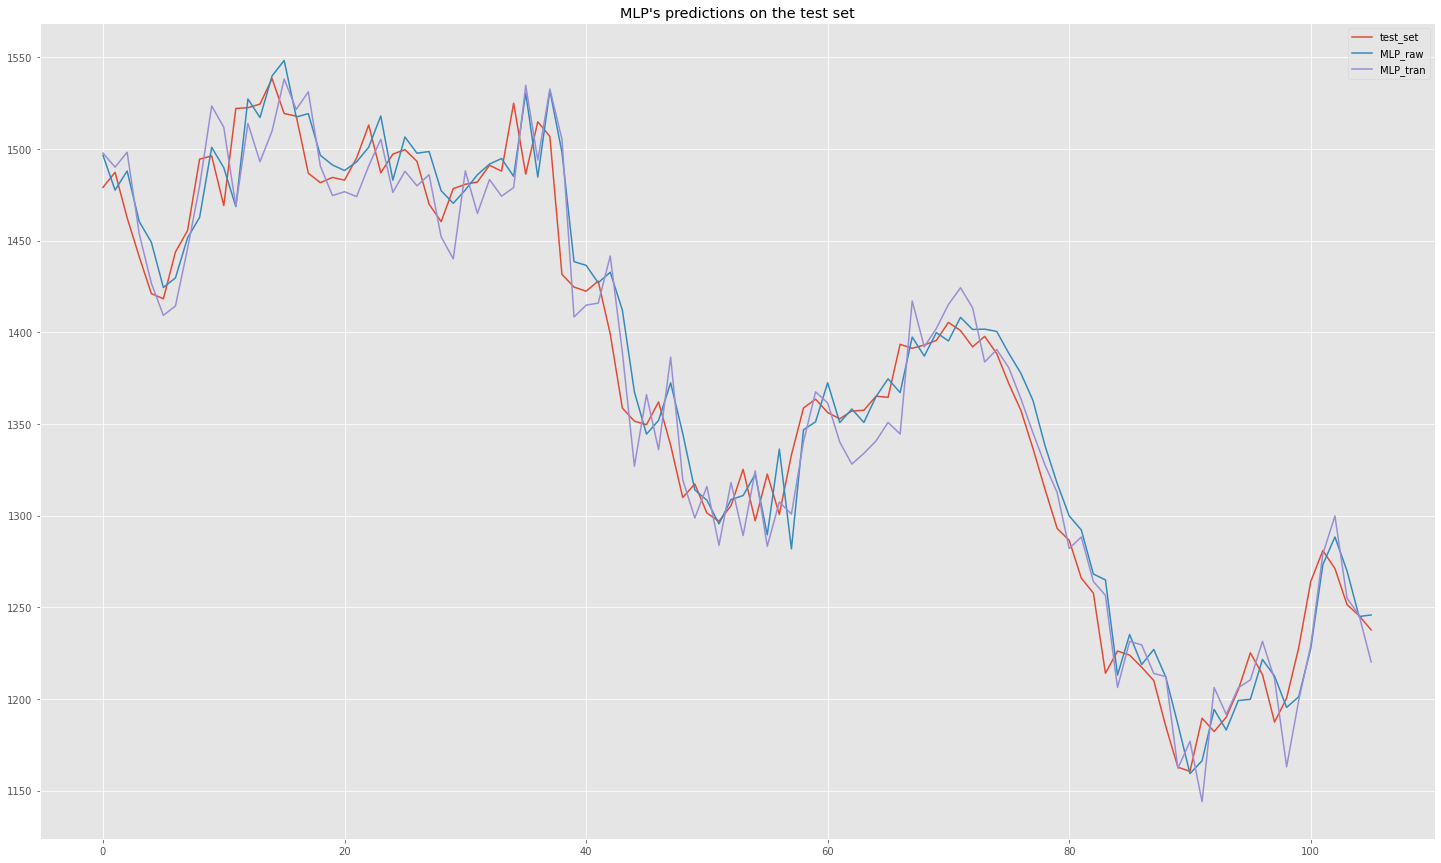

In [12]:
model = 'MLP'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

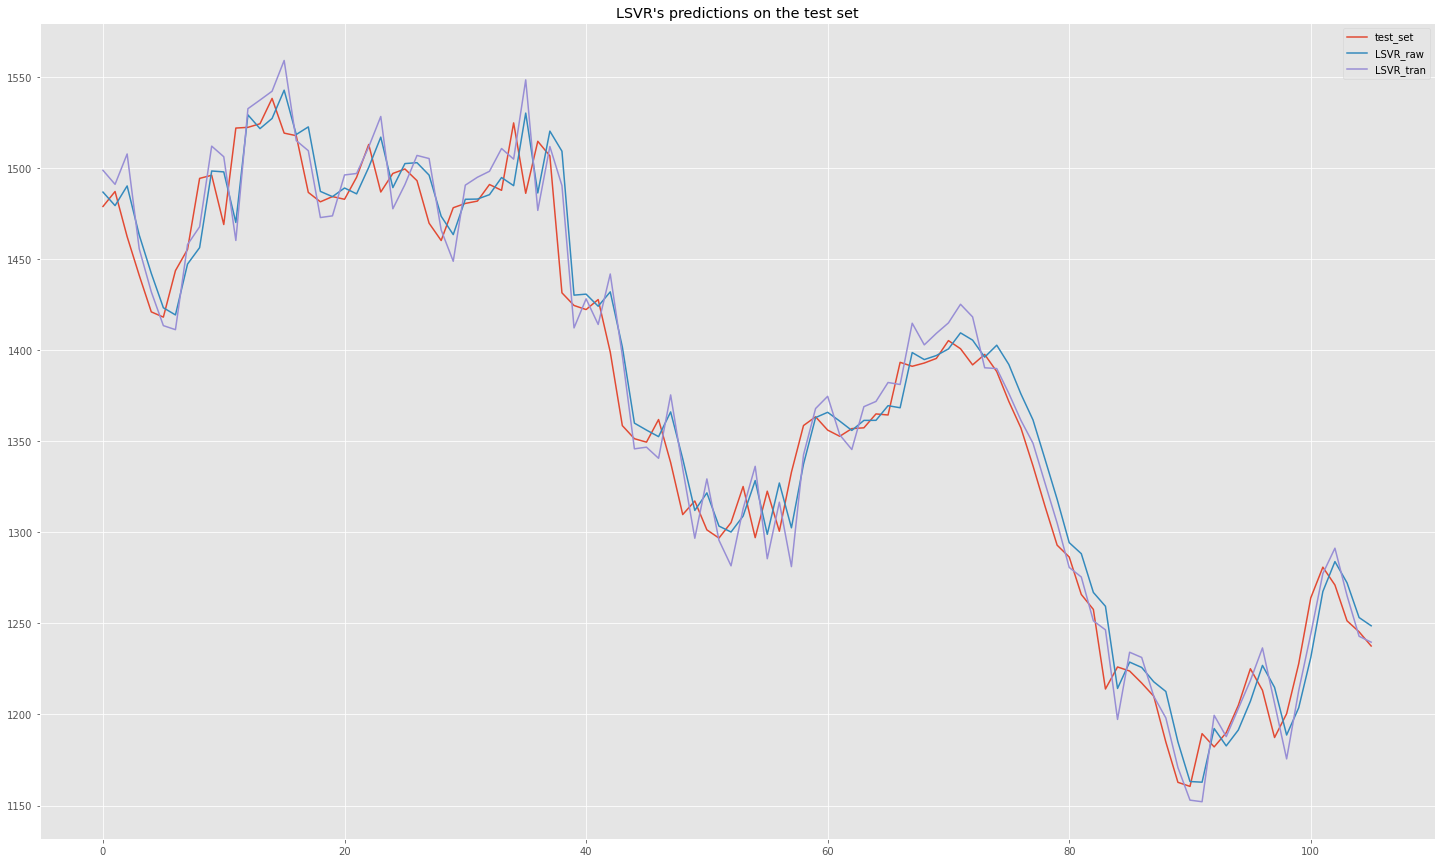

In [13]:
model = 'LSVR'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

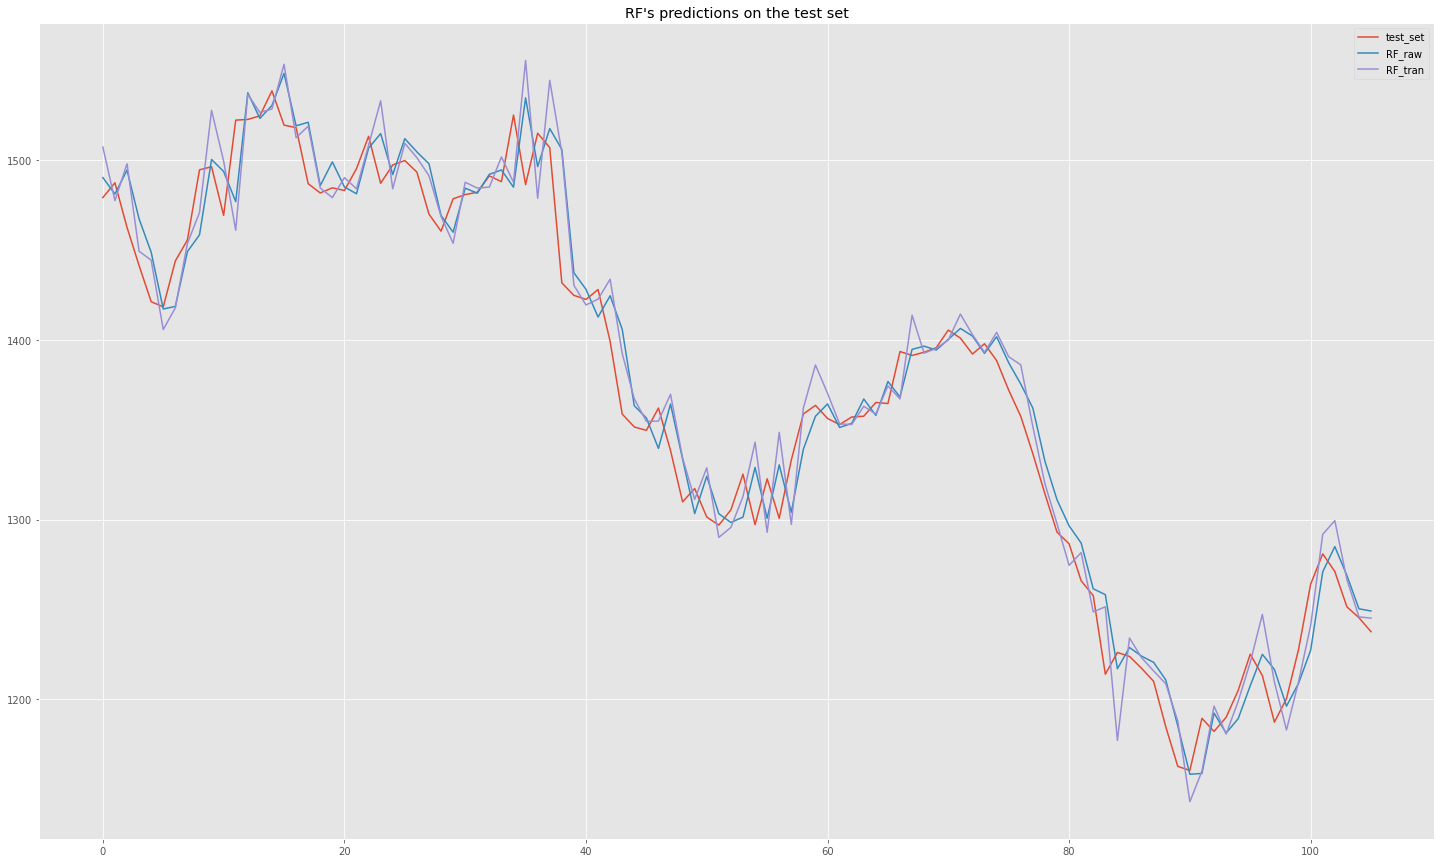

In [14]:
model = 'RF'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

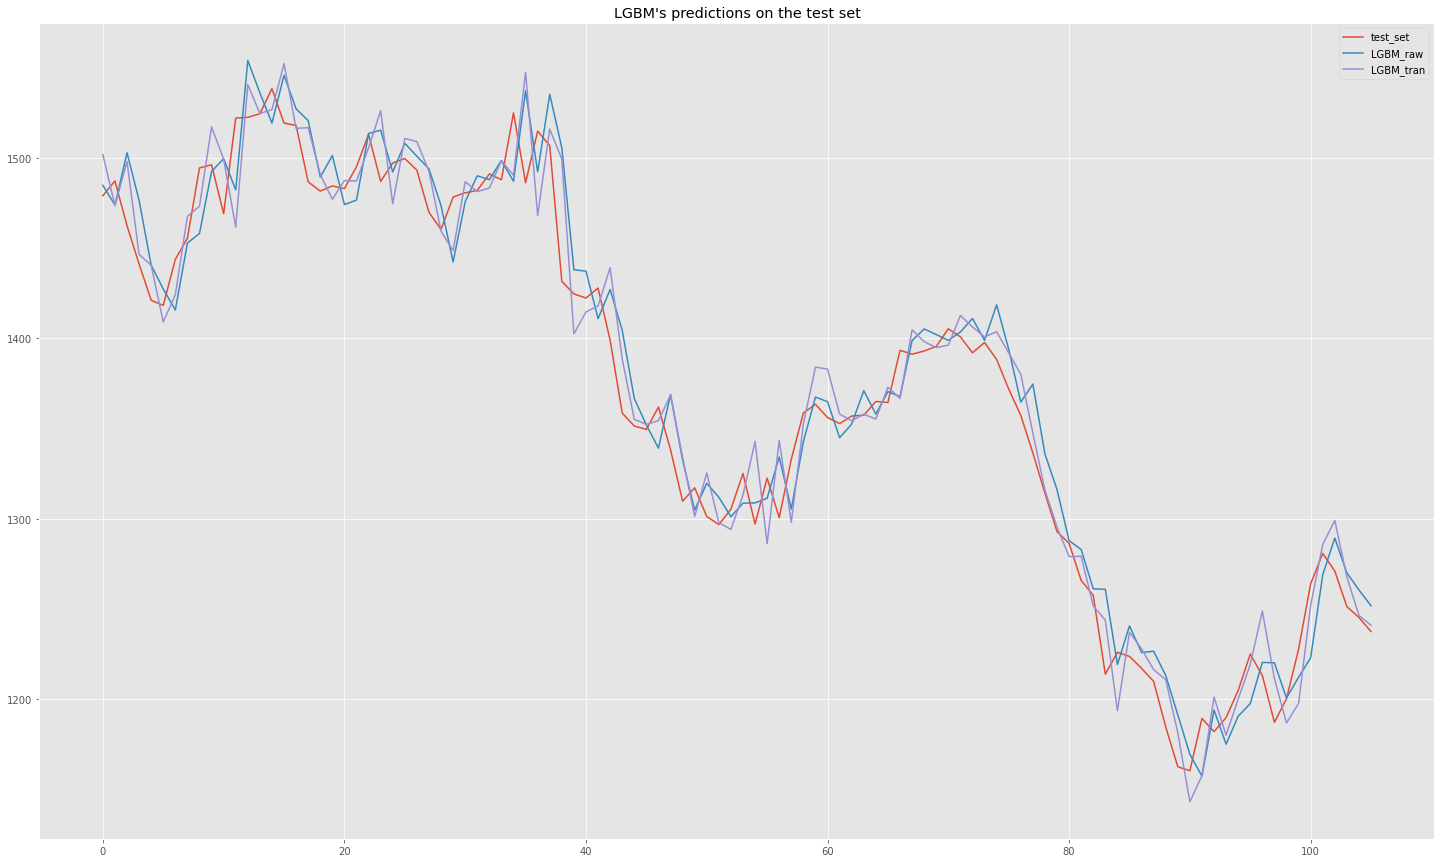

In [15]:
model = 'LGBM'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

In [16]:
use = '2040'

In [17]:
# filter out the test set

test_size = run_infos[0]['config input']['modelling config']['test size']
test_set_count = int(len(ts[use]) * test_size)

test_set = ts[use][-(test_set_count):]

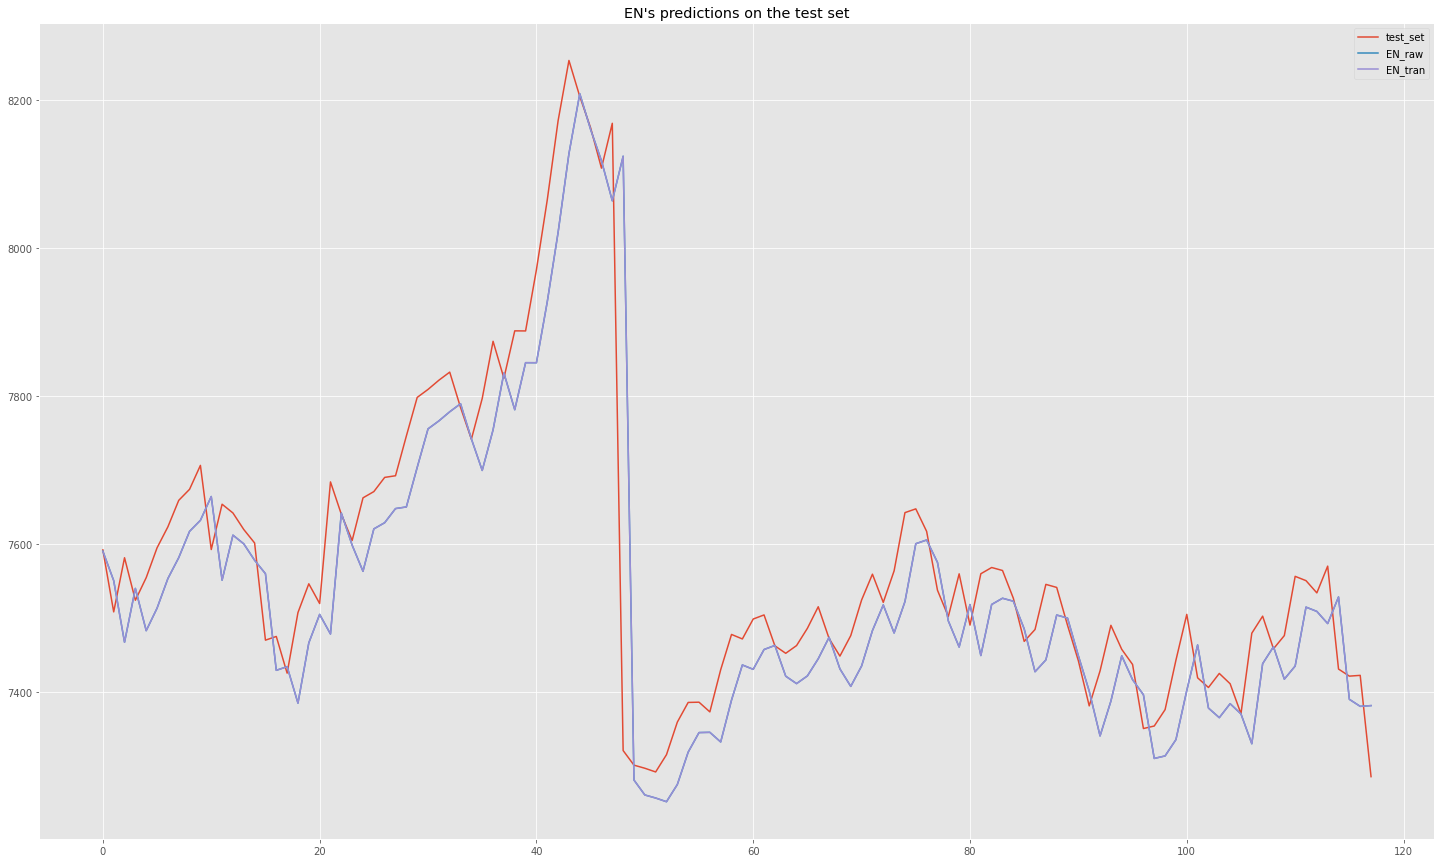

In [18]:
model = 'EN'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

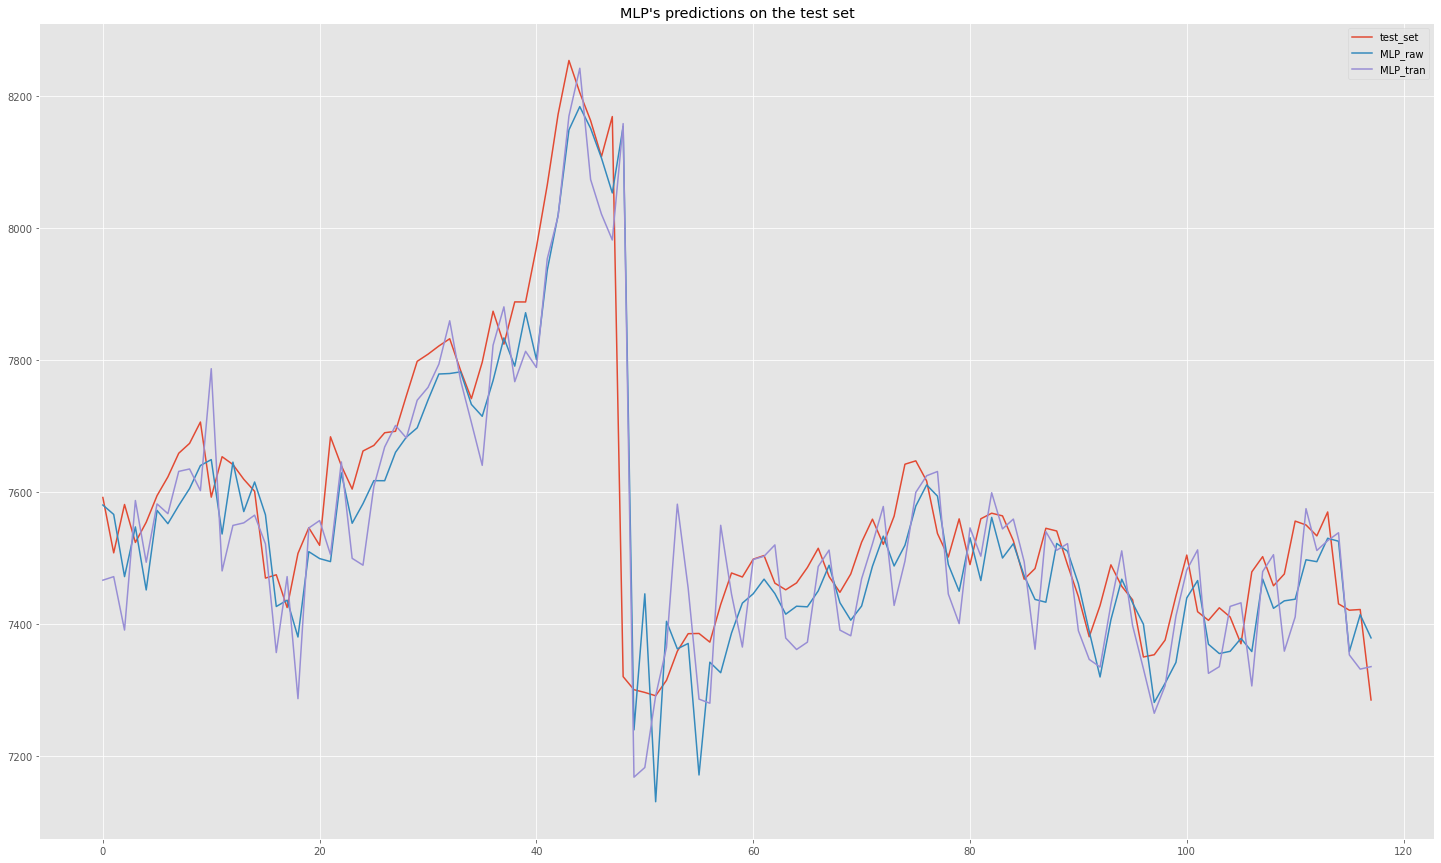

In [19]:
model = 'MLP'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

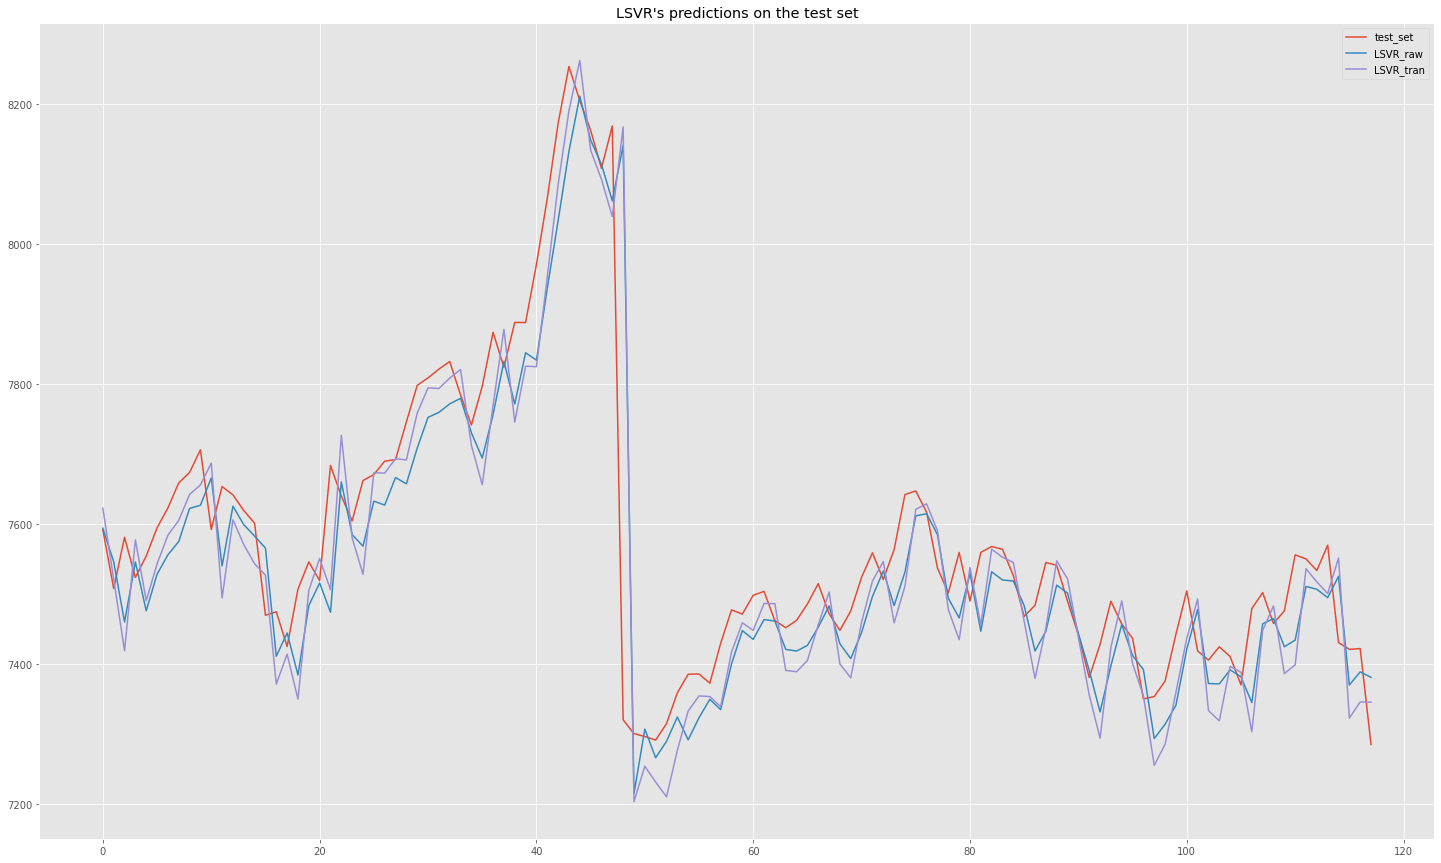

In [20]:
model = 'LSVR'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

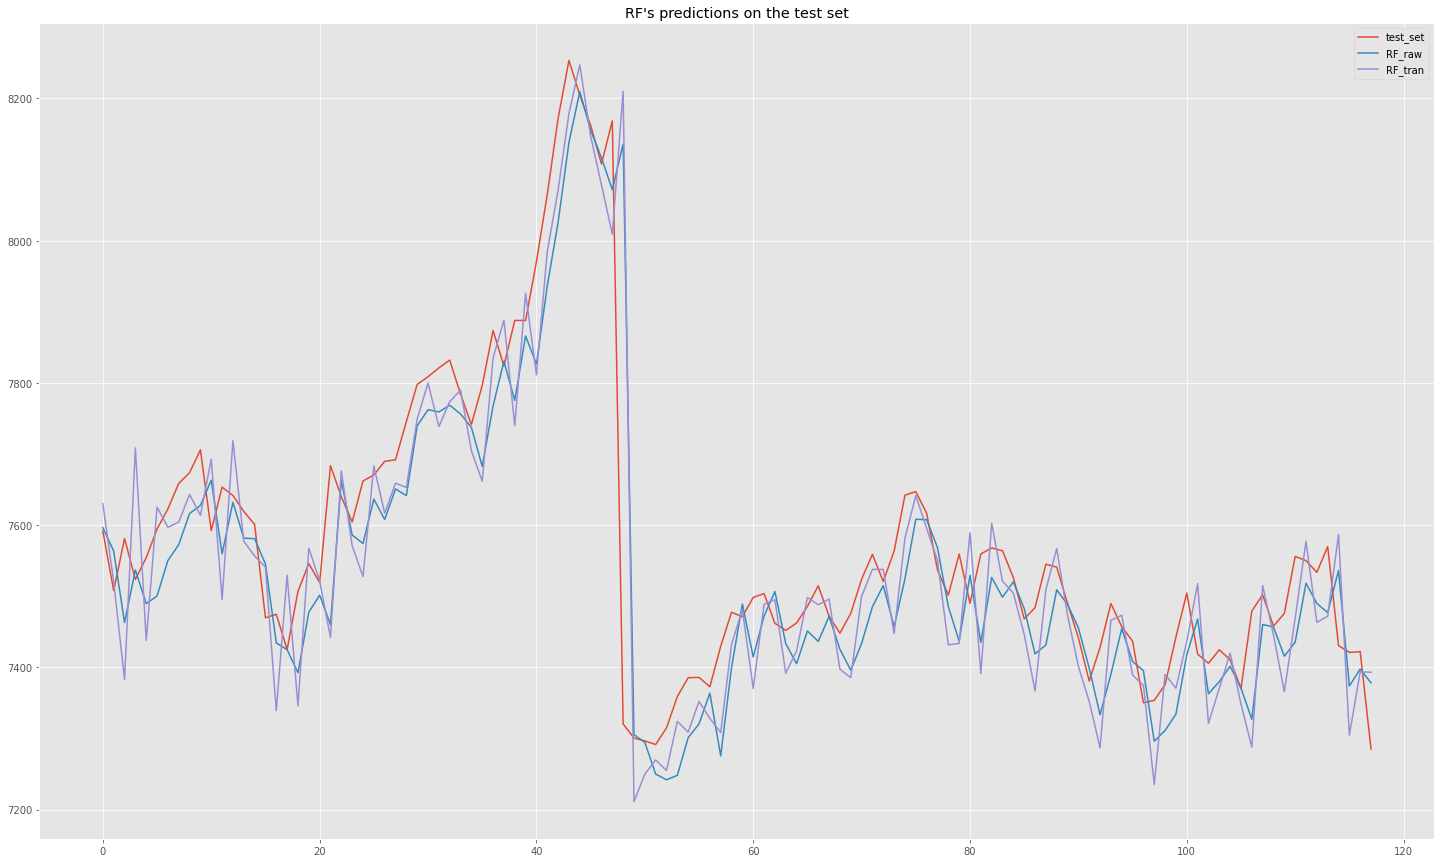

In [21]:
model = 'RF'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

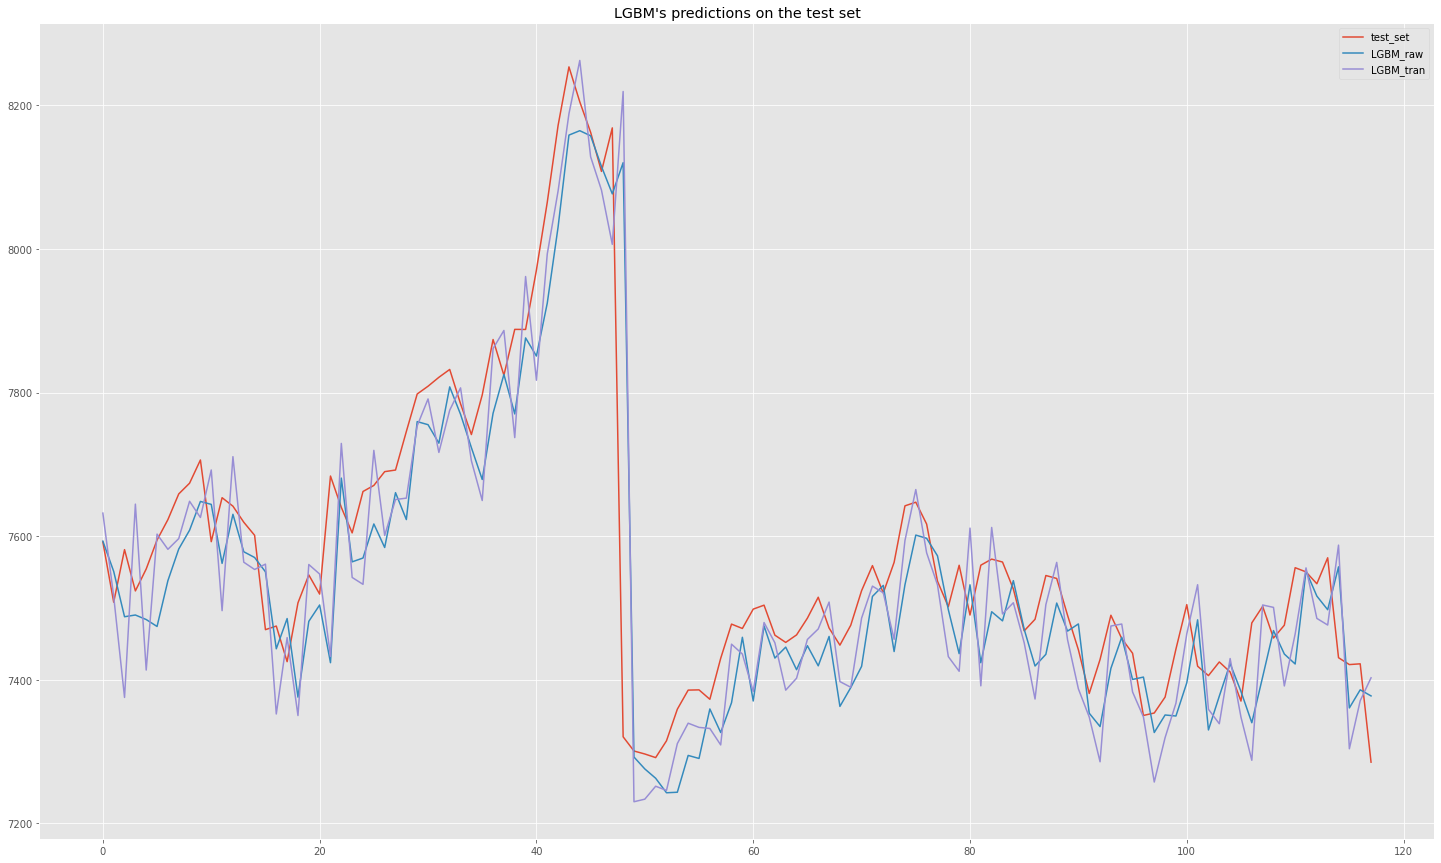

In [22]:
model = 'LGBM'

plt.figure(figsize=(25, 15))
plt.plot(test_set, label='test_set')
plt.plot(agent_infos[f'{model}_raw'][use]['y hats'], label=f'{model}_raw')
plt.plot(agent_infos[f'{model}_tran'][use]['y hats'], label=f'{model}_tran')
plt.title(f'{model}\'s predictions on the test set')
plt.legend()
plt.show()

## Statistics of overall performance

In this section, we calculate some statistics that concludes the general performance of each agent over the time series played.

In addition to SMAPE, we compute the ranking of each agent per time series. So each agent will have a ranking for a time series, ranging from 1 to the number of agent involved. I store this ranking info to the `agent_infos` dictionary, as how SMAPE is stored for each agent per time series.

In [23]:
for agent, plays in agent_infos.items():
    for series, play_info in plays.items():
        score = play_info['test SMAPE']
        lower = [1 for a in agent_infos.keys() if agent_infos[a][series]['test SMAPE']-score < 0]
        play_info['ranking'] = sum(lower) + 1

In [24]:
numbers = {
    agent: {
        'SMAPEs': [],
        'rankings': []
    } for agent in agent_infos
}

stats = {
    agent: {
        'mean SMAPE': None,
        'std. SMAPE': None,
        'mean ranking': None,
        'std. ranking': None
    } for agent in agent_infos
}

for agent, plays in agent_infos.items():
    for series, play_info in plays.items():
        numbers[agent]['SMAPEs'].append(play_info['test SMAPE'])
        numbers[agent]['rankings'].append(play_info['ranking'])
    
    stats[agent]['mean SMAPE'] = np.mean(numbers[agent]['SMAPEs'])
    stats[agent]['std. SMAPE'] = np.std(numbers[agent]['SMAPEs'])
    stats[agent]['mean ranking'] = np.mean(numbers[agent]['rankings'])
    stats[agent]['std. ranking'] = np.std(numbers[agent]['rankings'])

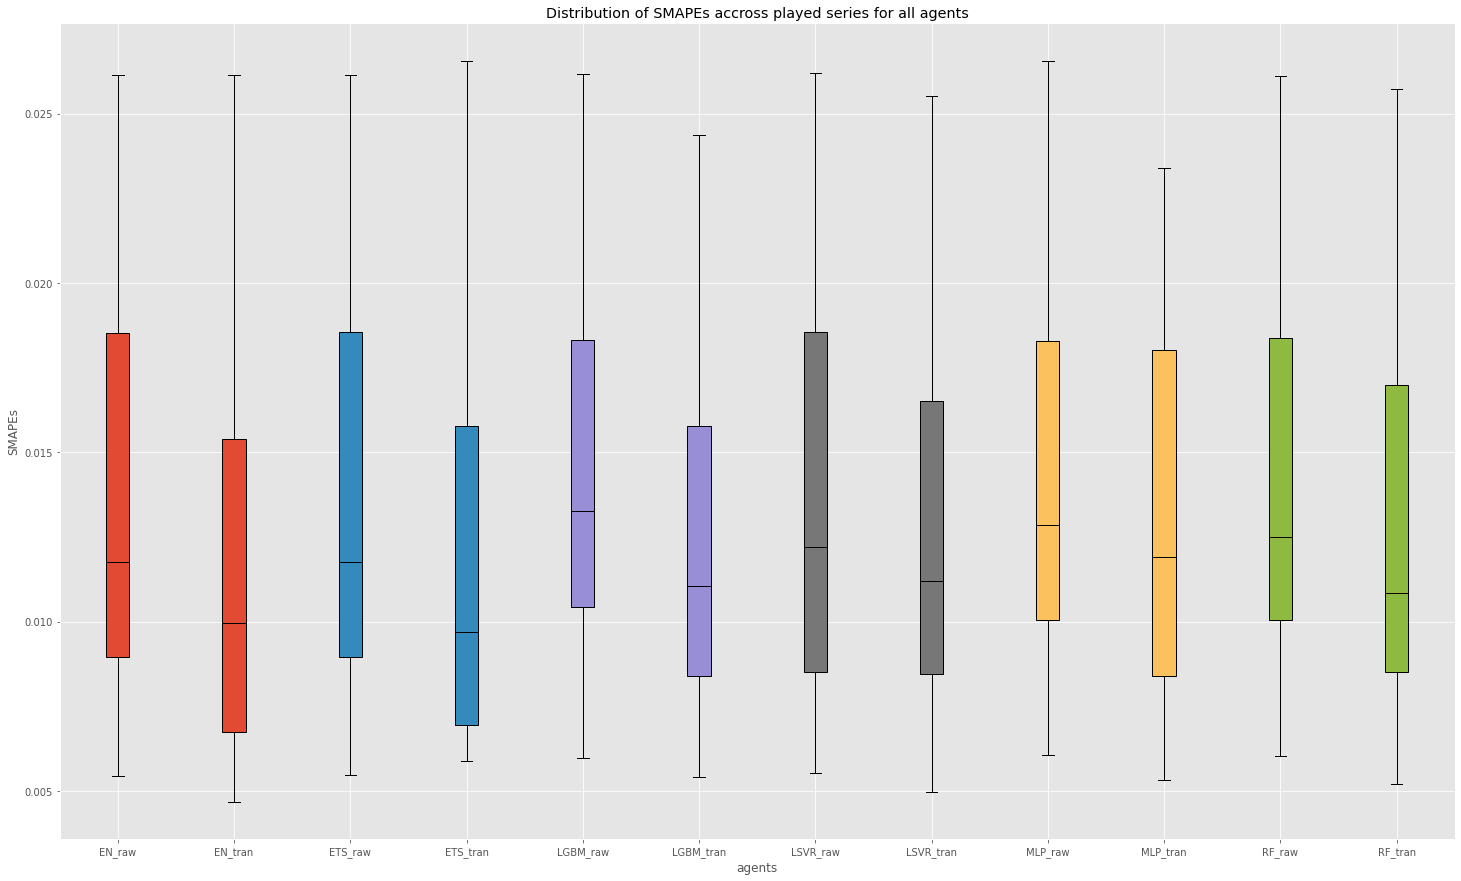

In [25]:
plt.figure(figsize= (25, 15))
n_agents = len(list(numbers.keys()))
colors = [f'C{i}' for i in range(n_agents//2)]
meanprop = dict(marker='D', markerfacecolor='black', markersize=10)

box = plt.boxplot(
    [agent['SMAPEs'] for agent in numbers.values()],
    showbox=True,
    showfliers=False,
    labels=list(numbers.keys()),
    widths=0.2,
    showmeans=False,
    meanprops=meanprop,
    patch_artist=True)

for i, patch in enumerate(box['boxes']):
    c = i // (n_agents//(n_agents//2))
    patch.set_facecolor(colors[c])
    box['medians'][i].set_color('k')

plt.title(f'Distribution of SMAPEs accross played series for all agents')
plt.xlabel('agents')
plt.ylabel('SMAPEs')
plt.show()

## Ranking of the agents

In this section, we compute the alpha-confidence interval of the rankings for the agents.

In [26]:
series_ran = agent_infos['MLP_raw'].keys()
n_series_ran = len(series_ran)

alpha = 0.1
Q = len(list(agent_infos.keys()))
P = n_series_ran
dist = np.random.standard_normal(size=Q)
r_lower, r_upper = np.min(dist), np.max(dist)
qrange = list(np.arange(r_lower, r_upper, step=(r_upper-r_lower)/100))
q_alpha_Q = qrange[-int(alpha*100)]

def conf_limit(Q, P, mean_R, q_alpha_Q):
    stat = 0.5 * q_alpha_Q * np.sqrt(Q*(Q+1)/(12 * P))
    return round(mean_R-stat, 6), round(mean_R+stat, 6)

for agent in agent_infos.keys():
    stats[agent][f'{100-int(alpha*100)}% ranking confi. limits'] = conf_limit(Q, P, stats[agent]['mean ranking'], q_alpha_Q)

leaderboard = pd.DataFrame(stats)
leaderboard

,EN_raw,EN_tran,ETS_raw,ETS_tran,LGBM_raw,LGBM_tran,LSVR_raw,LSVR_tran,MLP_raw,MLP_tran,RF_raw,RF_tran
mean SMAPE,0.109008,0.107565,0.109016,0.107874,0.109635,0.108036,0.109106,0.108381,0.109535,0.108212,0.109246,0.108293
std. SMAPE,0.242485,0.243037,0.242245,0.242853,0.242173,0.241847,0.242571,0.242276,0.242154,0.241378,0.242273,0.242008
mean ranking,6.35,3.05,5.9,5.0,9.2,5.95,7.15,6.4,9.05,6.35,7.1,6.3
std. ranking,2.868362,3.073679,2.681418,3.660601,2.4,3.556332,3.086665,2.8,2.312466,4.186586,2.605763,3.132092
90% ranking confi. limits,"(5.789702, 6.910298)","(2.489702, 3.610298)","(5.339702, 6.460298)","(4.439702, 5.560298)","(8.639702, 9.760298)","(5.389702, 6.510298)","(6.589702, 7.710298)","(5.839702, 6.960298)","(8.489702, 9.610298)","(5.789702, 6.910298)","(6.539702, 7.660298)","(5.739702, 6.860298)"


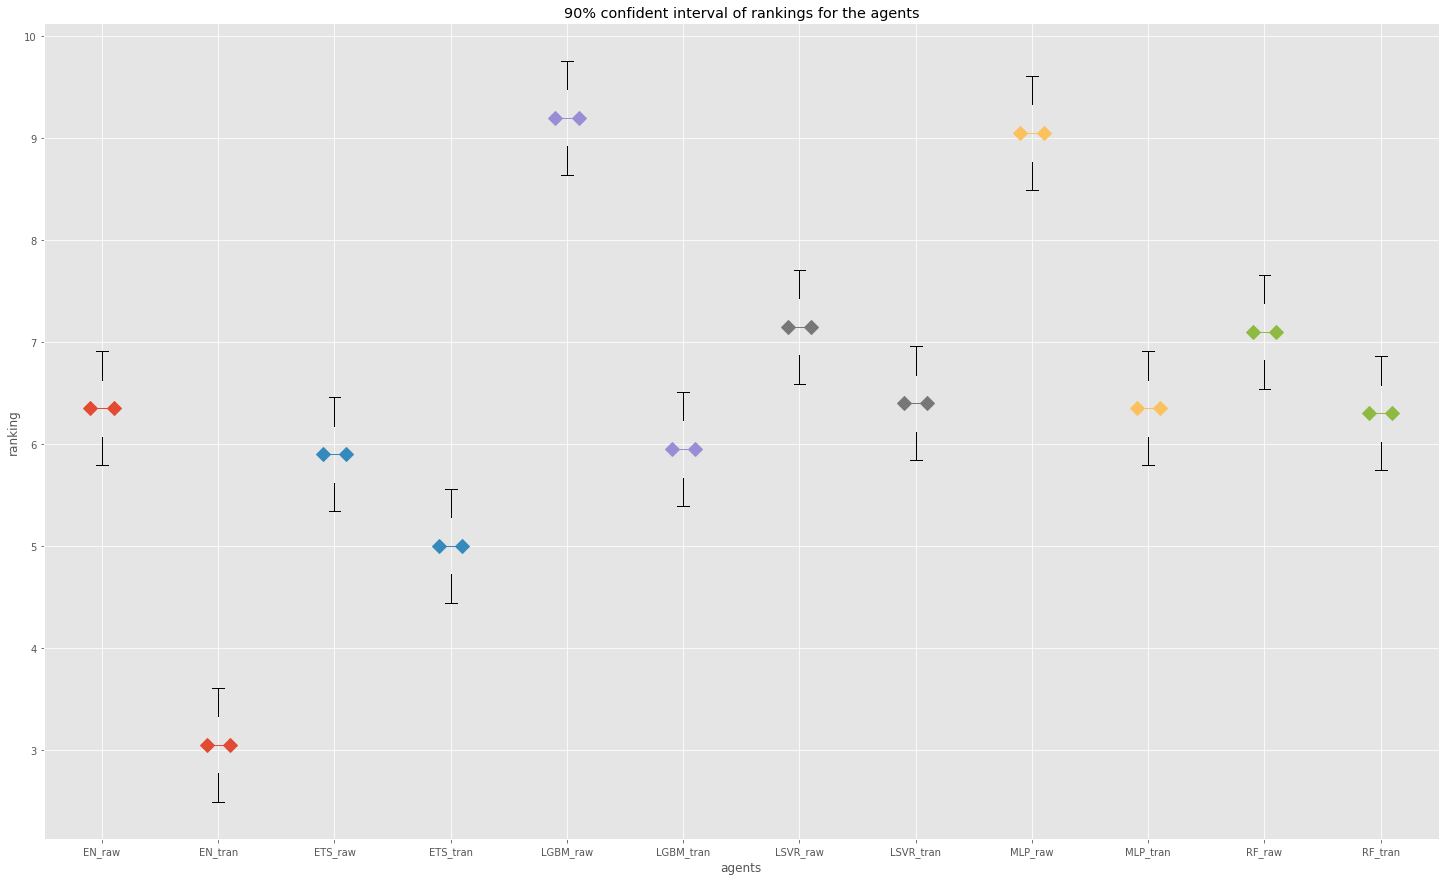

In [27]:
n_agents = len(list(numbers.keys()))
colors = [f'C{i}' for i in range(n_agents//2)]
medianprop = dict(marker='D', markersize=10)
plt.figure(figsize= (25, 15))
box = plt.boxplot(
    [
        [
            agent[f'{100-int(alpha*100)}% ranking confi. limits'][0],
            agent['mean ranking'],
            agent[f'{100-int(alpha*100)}% ranking confi. limits'][1]
        ] for agent in stats.values()
    ],
    showbox=False,
    labels=list(numbers.keys()),
    widths=0.2,
    medianprops=medianprop,
    patch_artist=True)

for i, patch in enumerate(box['medians']):
    c = i // (n_agents//(n_agents//2))
    patch.set_color(colors[c])

plt.title(f'{100-int(alpha*100)}% confident interval of rankings for the agents')
plt.xlabel('agents')
plt.ylabel('ranking')
plt.show()

## Fraction best

In this section, we compute another performance measure, called the fraction-best measure. Building on our basis performance measure SMAPE, we compute how much of a fraction out of all played time series that a model beats all other models. This measure lets us know the potential of an agent being exceptionally good conditional on the given datasets.

The results are shown in the last row of the table.

In [28]:
for agent, play_info in stats.items():
    play_info['frac best'] = np.sum([1 for r in numbers[agent]['rankings'] if r == 1])/n_series_ran

leaderboard = pd.DataFrame(stats)
leaderboard

,EN_raw,EN_tran,ETS_raw,ETS_tran,LGBM_raw,LGBM_tran,LSVR_raw,LSVR_tran,MLP_raw,MLP_tran,RF_raw,RF_tran
mean SMAPE,0.109008,0.107565,0.109016,0.107874,0.109635,0.108036,0.109106,0.108381,0.109535,0.108212,0.109246,0.108293
std. SMAPE,0.242485,0.243037,0.242245,0.242853,0.242173,0.241847,0.242571,0.242276,0.242154,0.241378,0.242273,0.242008
mean ranking,6.35,3.05,5.9,5.0,9.2,5.95,7.15,6.4,9.05,6.35,7.1,6.3
std. ranking,2.868362,3.073679,2.681418,3.660601,2.4,3.556332,3.086665,2.8,2.312466,4.186586,2.605763,3.132092
90% ranking confi. limits,"(5.789702, 6.910298)","(2.489702, 3.610298)","(5.339702, 6.460298)","(4.439702, 5.560298)","(8.639702, 9.760298)","(5.389702, 6.510298)","(6.589702, 7.710298)","(5.839702, 6.960298)","(8.489702, 9.610298)","(5.789702, 6.910298)","(6.539702, 7.660298)","(5.739702, 6.860298)"
frac best,0.0,0.55,0.05,0.1,0.0,0.0,0.05,0.0,0.0,0.25,0.0,0.0


# Feature importance analysis

In this section, we investigate the parameters estimated by the machine learning models to gain more insights on how the models learn the problems. In particular, we go through

- feature importance reported by the tree-based models (RF, LGBM)
- coefficients estimated by the linear regression model (EN)

In [29]:
# find out the indices of the series played that I have the feature importances recorded
runs =['12-07-2022--17-41-28']
played = []

for run in runs:
    with open(f'{run}/EN_tran.json', 'r') as file:
        temp = json.load(file)
    played += list(temp.keys())

played

['2040',
 '2041',
 '2044',
 '2045',
 '2078',
 '2080',
 '2081',
 '2137',
 '2214',
 '2292',
 '2310',
 '2315',
 '2317',
 '2370',
 '2425',
 '2432',
 '2439',
 '2440',
 '2483',
 '2484']

In [30]:
# find out the maximum number of lags possible
max_n_lag = 21
states = True
if states:
    n_states = 8
else:
    n_states = 0

## Tree-based models

In this section, we investigate the feature importance reported by the tree-based methods.

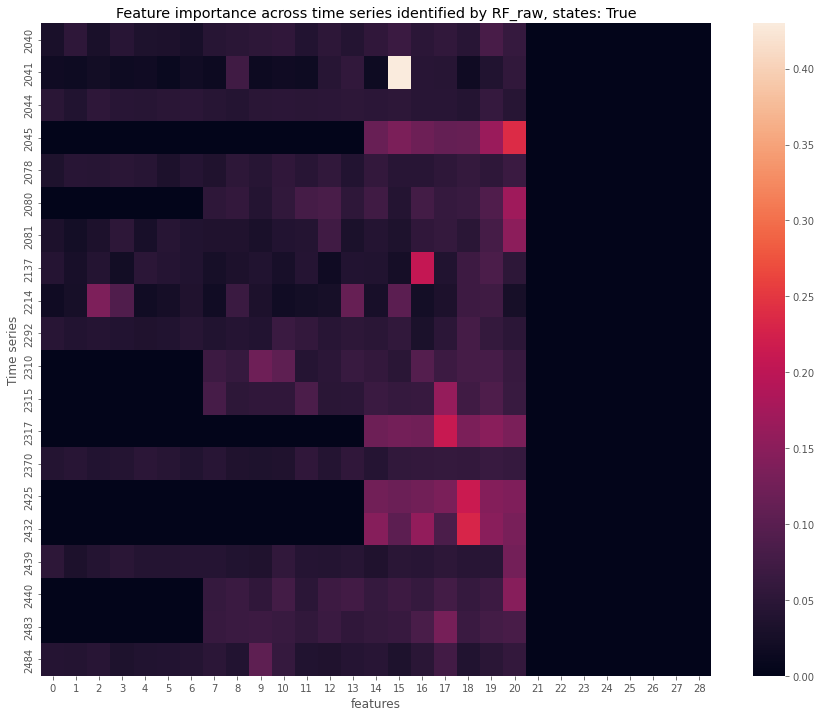

In [31]:
import matplotlib.pylab as pltlab
import seaborn as sns

model = 'RF_raw'

heatmap_grid = []

for id, play in agent_infos[model].items():
    if id not in played: continue

    fi = play['feature importances'][-1]
    if len(fi) == max_n_lag:
        heatmap_grid.append(fi + [0 for _ in range(n_states)])
    else:
        n_gap = max_n_lag - len(fi)
        heatmap_grid.append([0 for _ in range(n_gap)] + fi + [0 for _ in range(n_states)])

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=played)
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Feature importance across time series identified by {model}, states: {states}')
plt.show()

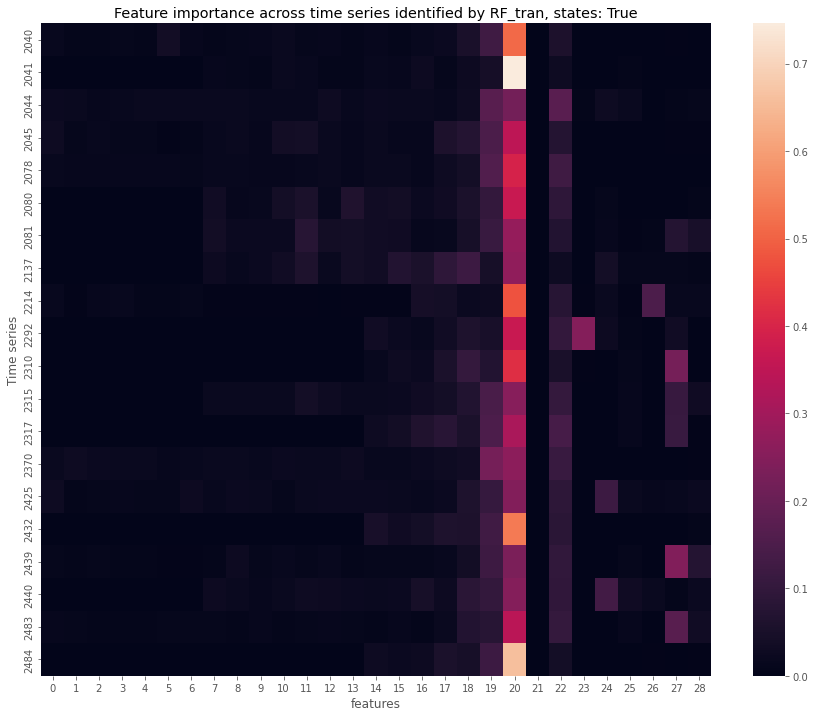

In [32]:
model = 'RF_tran'

heatmap_grid = []

for id, play in agent_infos[model].items():
    if id not in played: continue
    fi = play['feature importances'][-1]
    if len(fi) == max_n_lag + n_states:
        heatmap_grid.append(fi)
    else:
        n_gap = max_n_lag + n_states - len(fi)
        heatmap_grid.append([0 for _ in range(n_gap)] + fi)

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=played)
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Feature importance across time series identified by {model}, states: {states}')
plt.show()

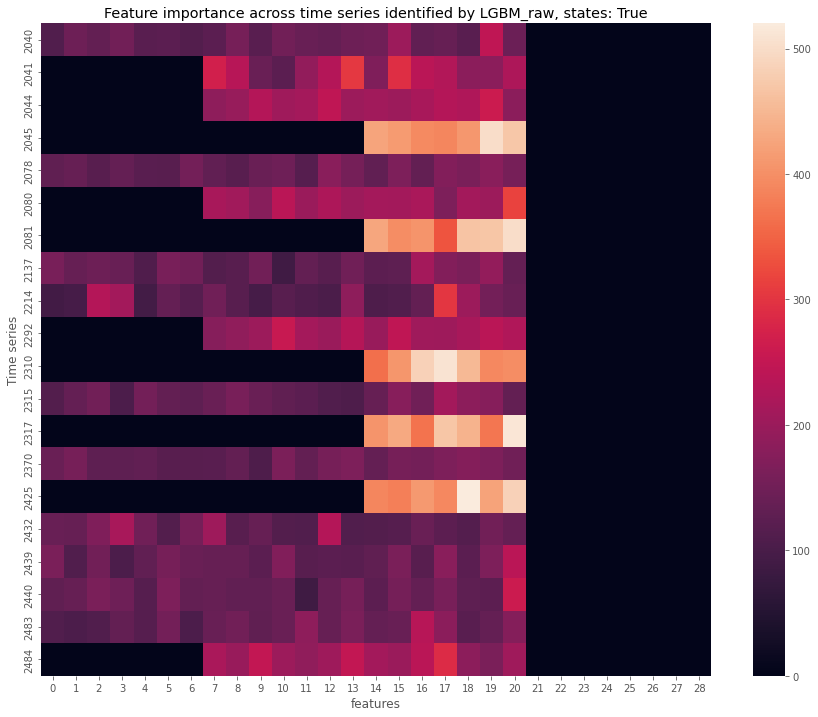

In [33]:
model = 'LGBM_raw'

heatmap_grid = []

for id, play in agent_infos[model].items():
    if id not in played: continue
    fi = play['feature importances'][-1]
    if len(fi) == max_n_lag:
        heatmap_grid.append(fi + [0 for _ in range(n_states)])
    else:
        n_gap = max_n_lag - len(fi)
        heatmap_grid.append([0 for _ in range(n_gap)] + fi + [0 for _ in range(n_states)])

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=played)
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Feature importance across time series identified by {model}, states: {states}')
plt.show()

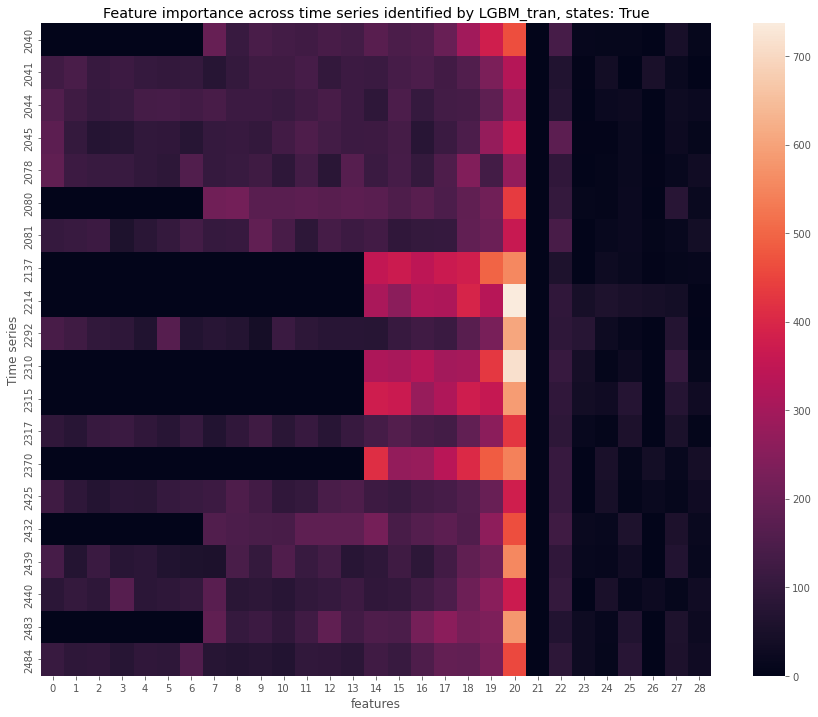

In [34]:
model = 'LGBM_tran'

heatmap_grid = []

for id, play in agent_infos[model].items():
    if id not in played: continue
    fi = play['feature importances'][-1]
    if len(fi) == max_n_lag + n_states:
        heatmap_grid.append(fi)
    else:
        n_gap = max_n_lag + n_states - len(fi)
        heatmap_grid.append([0 for _ in range(n_gap)] + fi)

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=played)
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Feature importance across time series identified by {model}, states: {states}')
plt.show()

# Linear regression model

In this section, we investigate the coefficients estimated by the linear regression model, in this case, EN. Note that since we fitted the linear model with intercept, we have an additional feature to the number of lags.

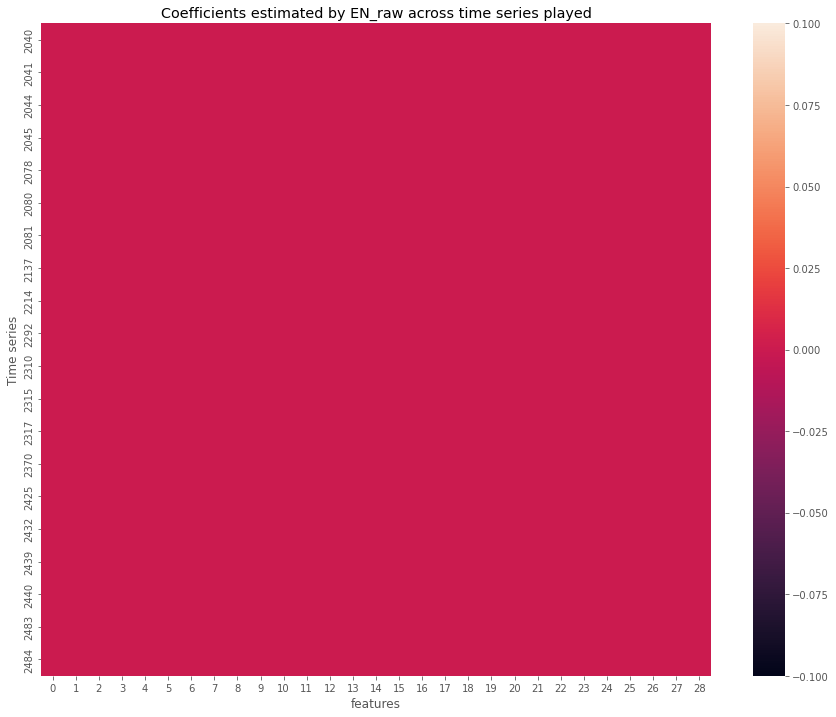

In [35]:
model = 'EN_raw'

# @NOTE: do not turn this to true, scale incomparable!!!
include_intercept = False

n_intercept = 1

heatmap_grid = []

for id, play in agent_infos[model].items():
    if id not in played: continue
    if include_intercept:
        coeffs = play['coeffs'][-1]
        n_intercept_c = n_intercept
    else:
        coeffs = play['coeffs'][-1][n_intercept:]
        n_intercept_c = 0
    if len(coeffs) == max_n_lag + n_intercept_c:
        heatmap_grid.append(coeffs + [0 for _ in range(n_states)])
    else:
        n_gap = max_n_lag  + n_intercept_c - len(coeffs)
        heatmap_grid.append([0 for _ in range(n_gap)] + coeffs + [0 for _ in range(n_states)])

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=played)
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Coefficients estimated by {model} across time series played')
plt.show()

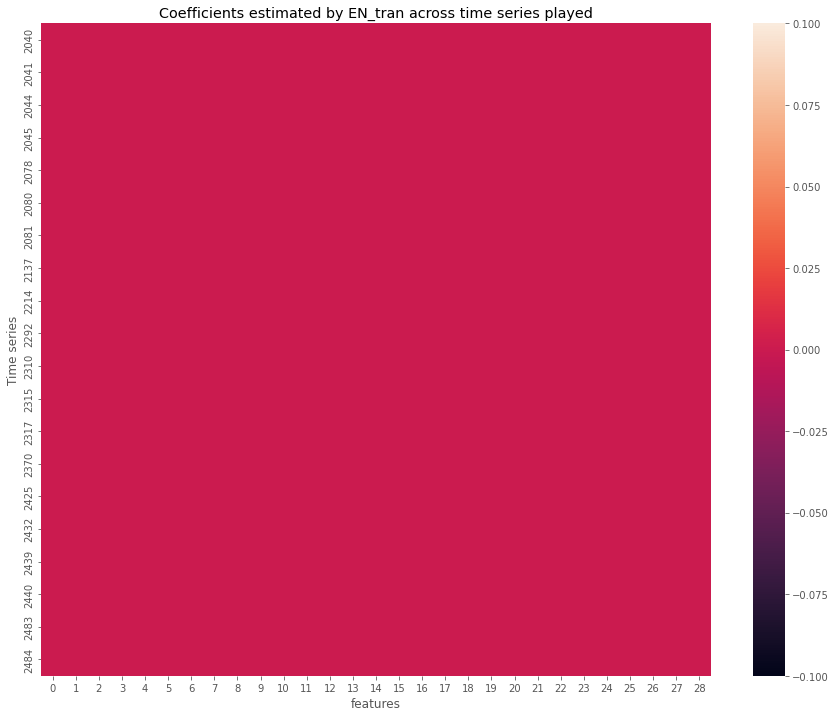

In [36]:
model = 'EN_tran'

# @NOTE: do not turn this to true, scale incomparable!!!
include_intercept = False

n_intercept = 1

heatmap_grid = []

for id, play in agent_infos[model].items():
    if id not in played: continue
    if include_intercept:
        coeffs = play['coeffs'][-1]
        n_intercept_c = n_intercept
    else:
        coeffs = play['coeffs'][-1][n_intercept:]
        n_intercept_c = 0
    if len(coeffs) == max_n_lag + n_intercept_c + n_states:
        heatmap_grid.append(coeffs)
    else:
        n_gap = max_n_lag + n_states + n_intercept_c - len(coeffs)
        heatmap_grid.append([0 for _ in range(n_gap)] + coeffs)

data = np.array(heatmap_grid)

plt.figure(figsize=(15, 12))
sns.heatmap(data, yticklabels=played)
plt.xlabel('features')
plt.ylabel('Time series')
plt.title(f'Coefficients estimated by {model} across time series played')
plt.show()

# Akima v.s. Linear interpolation

In this section, we investigate whether Akima interpolation is more popular than linear interpolation. The results printed by the code chunck show the number of times Akima interpolation been chosen verses linear interpolation been chosen.

In [37]:
count_akima = 0
count_linear = 0

for agent, plays in agent_infos.items():
    if 'raw' in agent: continue
    for series, play_info in plays.items():
        if play_info['best model']['interp kind'] == 'akima':
            count_akima += 1
        else:
            count_linear += 1
    print(f'{agent} akima:linear = {count_akima}:{count_linear}')
    count_akima = 0
    count_linear = 0

EN_tran akima:linear = 16:4
ETS_tran akima:linear = 9:11
LGBM_tran akima:linear = 3:17
LSVR_tran akima:linear = 3:17
MLP_tran akima:linear = 12:8
RF_tran akima:linear = 6:14


# Replicate the train to get more information

In the case of some of the information is not explicitly recorded from the experiment, there is a good chance it's implicitly contained in the recorded information. In this section, we derive the implicit information by replicating the traing using the information we have at hand.